# Look at the paired embeddings

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import (
    AdjacencySpectralEmbed,
    OmnibusEmbed,
    select_dimension,
)
from graspologic.match import GraphMatch
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import load_maggot_graph, load_palette
from pkg.io import savefig
from pkg.plot import set_theme


from src.visualization import adjplot  # TODO fix graspologic version and replace here

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "paired_embeddings"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
palette = dict(zip(["Left", "Right"], colors))
set_theme()

## Load and process data

In [2]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]

ll_mg, rr_mg, lr_mg, rl_mg = mg.bisect(paired=True)

ll_adj = ll_mg.sum.adj.copy()
rr_adj = rr_mg.sum.adj.copy()

nodes = ll_mg.nodes
nodes["_inds"] = range(len(nodes))
sorted_nodes = nodes.sort_values(["simple_group"])
sort_inds = sorted_nodes["_inds"]

ll_adj = ll_adj[np.ix_(sort_inds, sort_inds)]
rr_adj = rr_adj[np.ix_(sort_inds, sort_inds)]

adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

1144 in intersection of largest connected components.


## Investigate alignment methods

### Run the initial embedding using ASE

In [3]:


def embed(adj, n_components=40, ptr=False):
    if ptr:
        adj = pass_to_ranks(adj)
    elbow_inds, elbow_vals = select_dimension(augment_diagonal(adj), n_elbows=4)
    elbow_inds = np.array(elbow_inds)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    out_latent, in_latent = ase.fit_transform(adj)
    return out_latent, in_latent, ase.singular_values_, elbow_inds


def preprocess_for_embed(ll_adj, rr_adj, preprocess):
    if "binarize" in preprocess:
        ll_adj_to_embed = binarize(ll_adj)
        rr_adj_to_embed = binarize(rr_adj)

    if "rescale" in preprocess:
        ll_norm = np.linalg.norm(ll_adj_to_embed, ord="fro")
        rr_norm = np.linalg.norm(rr_adj_to_embed, ord="fro")
        mean_norm = (ll_norm + rr_norm) / 2
        ll_adj_to_embed *= mean_norm / ll_norm
        rr_adj_to_embed *= mean_norm / rr_norm
    return ll_adj_to_embed, rr_adj_to_embed


n_components = 8
max_n_components = 40
preprocess = ["binarize", "rescale"]

ll_adj_to_embed, rr_adj_to_embed = preprocess_for_embed(ll_adj, rr_adj, preprocess)

# for someone else to run this experiment too
# np.savetxt(
#     "maggot_connectome/results/outputs/align_investigation/left_adj.csv",
#     ll_adj_to_embed,
#     delimiter=",",
# )
# np.savetxt(
#     "maggot_connectome/results/outputs/align_investigation/right_adj.csv",
#     rr_adj_to_embed,
#     delimiter=",",
# )

left_out, left_in, left_sing_vals, left_elbow_inds = embed(
    ll_adj_to_embed, n_components=max_n_components
)
right_out, right_in, right_sing_vals, right_elbow_inds = embed(
    rr_adj_to_embed, n_components=max_n_components
)

### Plot screeplots

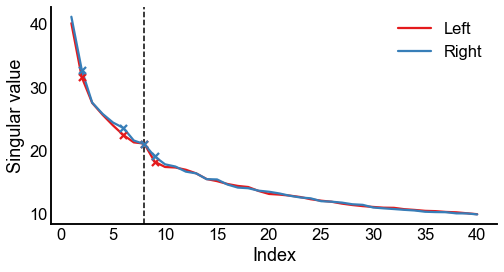

In [4]:


def screeplot(sing_vals, elbow_inds, color=None, ax=None, label=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.plot(range(1, len(sing_vals) + 1), sing_vals, color=color, label=label)
    plt.scatter(
        elbow_inds, sing_vals[elbow_inds - 1], marker="x", s=50, zorder=10, color=color
    )
    ax.set(ylabel="Singular value", xlabel="Index")
    return ax


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
screeplot(left_sing_vals, left_elbow_inds, color=palette["Left"], ax=ax, label="Left")
screeplot(
    right_sing_vals, right_elbow_inds, color=palette["Right"], ax=ax, label="Right"
)
ax.legend()
ax.axvline(n_components, color="black", linewidth=1.5, linestyle="--")
stashfig(f"screeplot-preprocess={preprocess}")

### Plot the latent positions without alignment

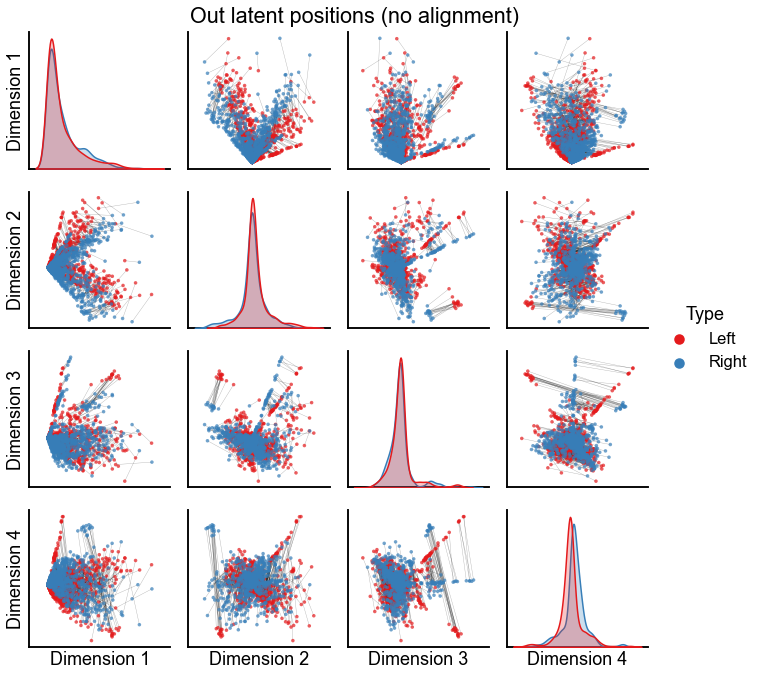

In [5]:

from matplotlib.collections import LineCollection


def add_connections(x1, x2, y1, y2, color="black", alpha=0.2, linewidth=0.2, ax=None):
    x1 = np.array(x1)
    x2 = np.array(x2)
    y1 = np.array(y1)
    y2 = np.array(y2)
    if ax is None:
        ax = plt.gca()

    coords = []
    for i in range(len(x1)):
        coords.append([[x1[i], y1[i]], [x2[i], y2[i]]])
    lc = LineCollection(
        coords,
        colors=color,
        linewidths=linewidth,
        alpha=alpha,
        zorder=0,
    )
    ax.add_collection(lc)


def plot_latents(left, right, title="", n_show=4, alpha=0.3, linewidth=0.4):
    if n_show > left.shape[1]:
        n_show = left.shape[1]
    plot_data = np.concatenate([left, right], axis=0)
    labels = np.array(["Left"] * len(left) + ["Right"] * len(right))
    pg = pairplot(plot_data[:, :n_show], labels=labels, title=title)
    axs = pg.axes
    for i in range(n_show):
        for j in range(n_show):
            if i != j:
                ax = axs[i, j]
                add_connections(
                    left[:, j],
                    right[:, j],
                    left[:, i],
                    right[:, i],
                    ax=ax,
                    alpha=alpha,
                    linewidth=linewidth,
                )
    return pg


pg = plot_latents(left_out, right_out, title="Out latent positions (no alignment)")
stashfig(f"out-latent-no-align-preprocess={preprocess}")

### Align the 3-dimensional out embeddings using known or predicted pairs

In [6]:


def run_alignments(X, Y, scale=False):
    X = X.copy()
    Y = Y.copy()
    if scale:
        X_norm = np.linalg.norm(X, ord="fro")
        Y_norm = np.linalg.norm(Y, ord="fro")
        avg_norms = (X_norm + Y_norm) / 2
        X = X * (avg_norms / X_norm)
        Y = Y * (avg_norms / Y_norm)
    op = OrthogonalProcrustes()
    X_trans_op = op.fit_transform(X, Y)
    sp = SeedlessProcrustes(init="custom", initial_Q=op.Q_)
    X_trans_sp = sp.fit_transform(X, Y)
    return X_trans_op, X_trans_sp


def calc_diff_norm(X, Y):
    return np.linalg.norm(X - Y, ord="fro")


n_components = 3  # this was a small dimension where we reject
op_known_left_out, sp_known_left_out = run_alignments(
    left_out[:, :n_components], right_out[:, :n_components]
)

### Plot the results of these two kinds of alignment using orthogonal Procrustes

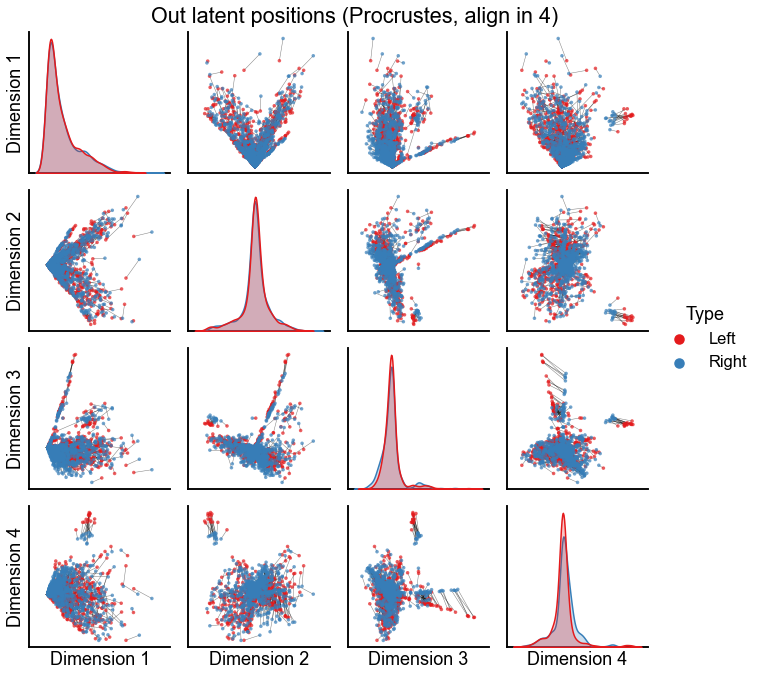

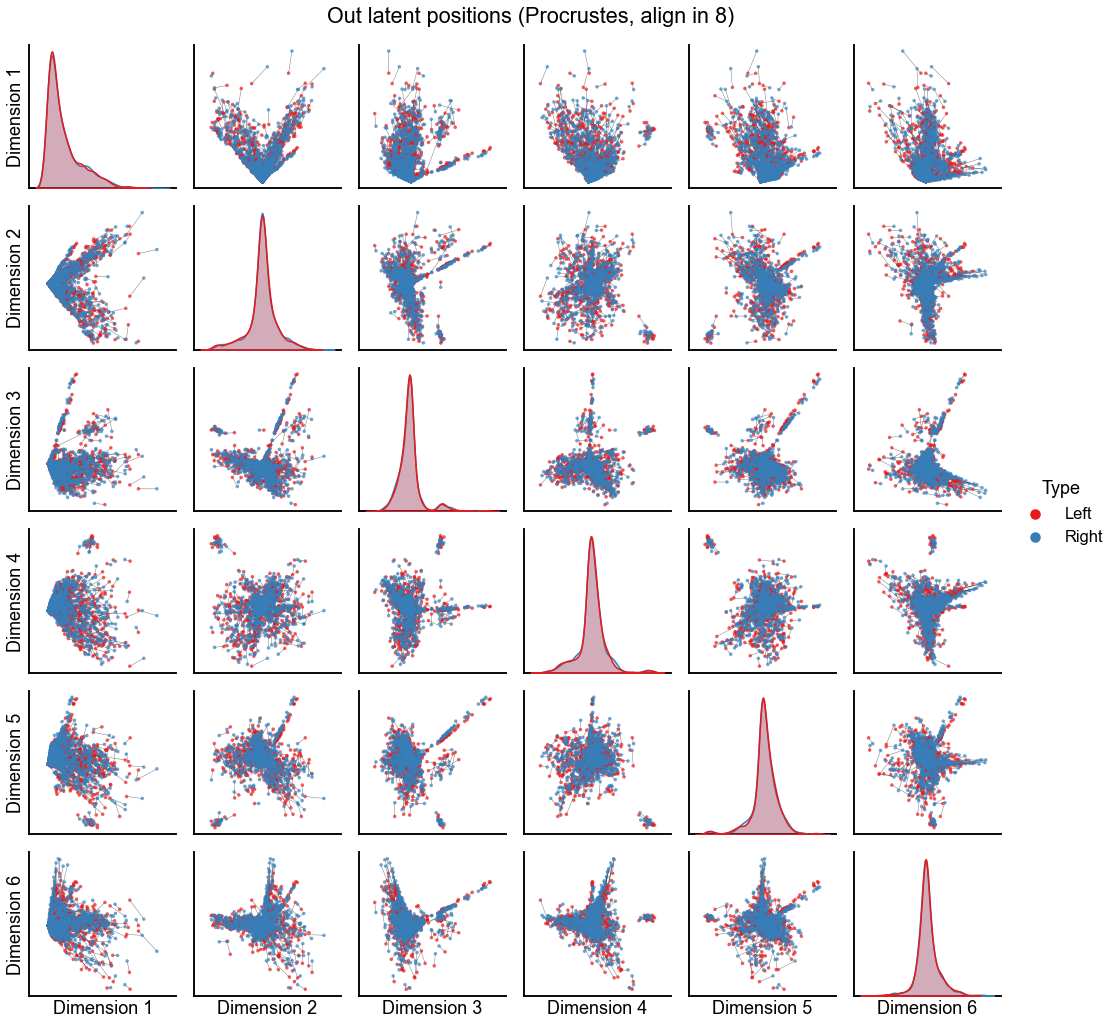

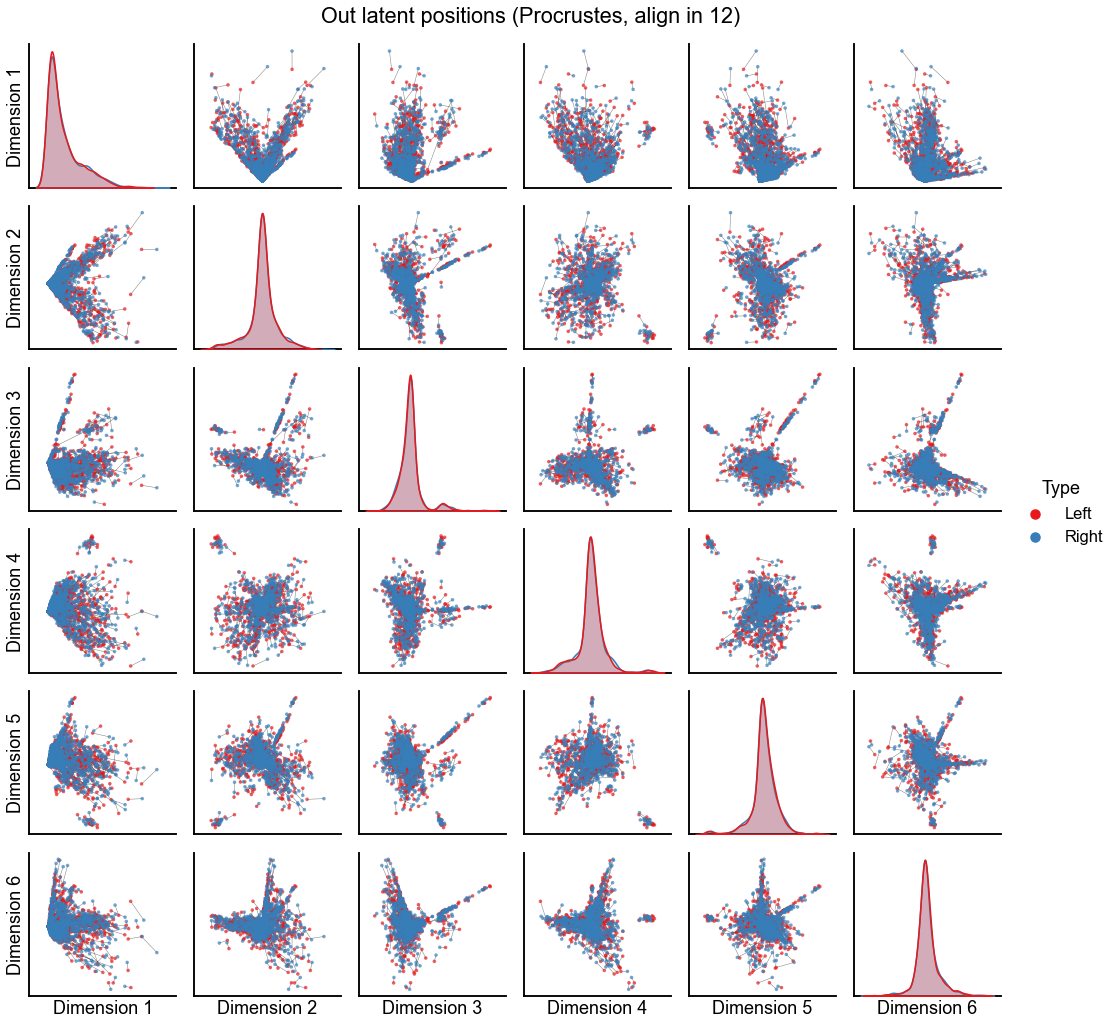

In [7]:
n_show = 6
for n_components in [4, 8, 12]:
    op_known_left_out, sp_known_left_out = run_alignments(
        left_out[:, :n_components], right_out[:, :n_components]
    )
    plot_latents(
        op_known_left_out,
        right_out[:, :n_components],
        f"Out latent positions (Procrustes, align in {n_components})",
        n_show=n_show,
        alpha=0.5,
        linewidth=0.5,
    )
    stashfig(f"out-latent-op-known-preprocess={preprocess}-n_components={n_components}")